In [667]:
from matplotlib import pyplot as plt
from skimage import data, io
import ipywidgets as widgets
from ipywidgets import Button, Layout
import cv2
import numpy as np
from skimage.filters import threshold_local
from skimage.color import rgb2gray
import numpy as np
from skimage.morphology import disk, dilation, erosion
from scipy.stats import moment
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from skimage import img_as_float

## Wybierz obraz

In [668]:
style = {'description_width': '40%'}

selector = widgets.Dropdown(
    options=[('Test eye 1', ['photos/Image_01L.jpg','photos/Image_01L_1stHO.png']),
             ('Test eye 2', ['photos/Image_02L.jpg','photos/Image_02L_1stHO.png']),
             ('Test eye 3', ['photos/Image_11L.jpg','photos/Image_11L_1stHO.png']),
             ('Test eye 4', ['photos/Image_13L.jpg','photos/Image_13L_1stHO.png']),
             ('Test eye 5', ['photos/Image_08R.jpg','photos/Image_08R_1stHO.png'])],
    value=['photos/Image_01L.jpg','photos/Image_01L_1stHO.png'],
    description='Image:',
    layout=Layout(width='50%', height='30px'),
    style=style
)

display(selector)

Dropdown(description='Image:', layout=Layout(height='30px', width='50%'), options=(('Test eye 1', ['photos/Ima…

## Potrzebne funkcje

In [669]:
def create_mask(image):
    img = rgb2gray(image)
    img[img[:, :] > 0.05] = 1
    img[img[:, :] <= 0.05] = 0
    img = erosion(img, disk(1))
    img = dilation(img, disk(3))
    img = erosion(img, disk(3))
    return img

def image(img):
    mask = create_mask(cv2.imread(img))
    img = cv2.imread(img,0)
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    block_size = 213
    adaptive_thresh = threshold_local(cl1, block_size, offset=10)
    binary_adaptive = cl1 > adaptive_thresh
    binary_adaptive = dilation(dilation(dilation(erosion(binary_adaptive))))
    binary_adaptive[mask == 0 ] = 1
    exit = np.zeros(binary_adaptive.shape)
    exit[binary_adaptive == True] = 0
    exit[binary_adaptive == False] = 1    
    exit = dilation(exit)
    return exit


def confusion_matrix(image, mask):
    result = []
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(image)):
        row = []
        for j in range(len(image[i])):
            if (image[i][j] == 1.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 255, 0]) #zielony
                    tp+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 0, 0]) #czerwony
                    fp+=1
            elif (image[i][j] == 0.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 0, 255]) #niebieski
                    fn+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 255, 255]) #biały
                    tn+=1
        result.append(row)
    return result, tp, fp, fn, tn

def create_matrix (img, hand):
    res, tp, fp, fn, tn = confusion_matrix(img, hand)
    #czułość
    tpr = tp / (tp + fn)
    #trafność
    ppv = (tp + tn) / (tn + fn + tp + fp)
    #swoistość
    spc = tn / (fp + tn)
    avg = (spc + tpr) / 2
    print("trafność:", ppv)
    print("czułość:", tpr)
    print("swoistość:", spc)
    print("średnia arytmetyczna czułości i swoistości:", avg)
    red_patch = mpatches.Patch(color='red', label='FP')
    blue_patch = mpatches.Patch(color='blue', label='FN')
    white_patch = mpatches.Patch(color='white', label='TN')
    green_patch = mpatches.Patch(color='green', label='TP')
    plt.legend(handles=[red_patch, blue_patch,white_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.imshow(res)
    
def get_features(img):
    cen_moments_2 = []
    cen_moments_3 = []
    cen_moments_4 = []
    cen_moments_5 = []
    for i in range(len(img)// 5):
        for j in range(len(img[0]) // 5):
            part_img = img [5*i:5*(i+1), 5*j:5*(j+1)].flatten()
            cen_moments_2.append(moment(part_img, moment = 2))
            cen_moments_3.append(moment(part_img, moment = 3))
            cen_moments_4.append(moment(part_img, moment = 4))
            cen_moments_5.append(moment(part_img, moment = 5))
    return list(map(list, zip(cen_moments_2, cen_moments_3, cen_moments_4, cen_moments_5)))

def get_labels(img):
    label = [] 
    for i in range(len(img) // 5):
        for j in range(len(img[0]) // 5):
            img_part = img[5*i : 5*(i+1), 5*j : 5*(j+1)]
            label.append(img_part[2,2])
    return label

def prepare(img, predicted,file):
    data = get_labels(img_as_float(cv2.imread(file,0)))
    x, y1 = img.shape
    pre = []
    hand = []
    k = 0
    for i in range(x//5):
        pre.append([])
        hand.append([])
        for j in range(y1//5):
            pre[i] += [predicted[k]]
            hand[i] += [data[k]]
            k += 1
    return pre, hand

def data(tab):
    X = []
    y = []
    for i in tab:
        img  = image(i[0])
        hand = img_as_float(cv2.imread(i[1],0))
        X += get_features(img)
        y += get_labels(hand)
    
    clf = DecisionTreeClassifier(criterion = "entropy")
    kfold = KFold(5, True, 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for train_index, test_index in kfold.split(X):
        for i in train_index:
            X_train.append(X[i])
            y_train.append(y[i])
        for h in test_index:
            X_test.append(X[h])
            y_test.append(y[h])
    clf = clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X, y, cv = 5)
    print ("Cross-validated scores:", scores)
    print("score ", clf.score(X_test, y_test))
    predictions = cross_val_predict(clf, X, y, cv=6)
    #print(predictions)
    return clf



## Obraz wejściowy

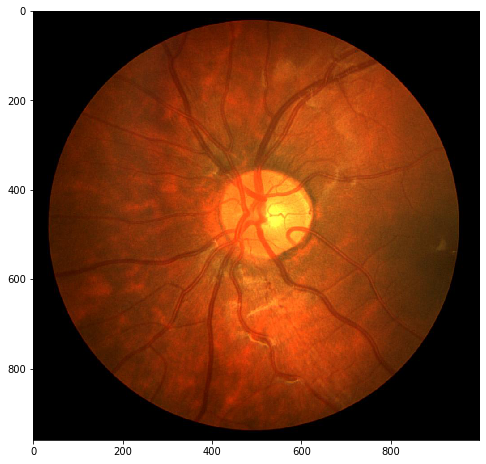

In [670]:
plt.figure(figsize=(8, 8))
plt.imshow(io.imread(selector.value[0]))

## Obraz wyjściowy

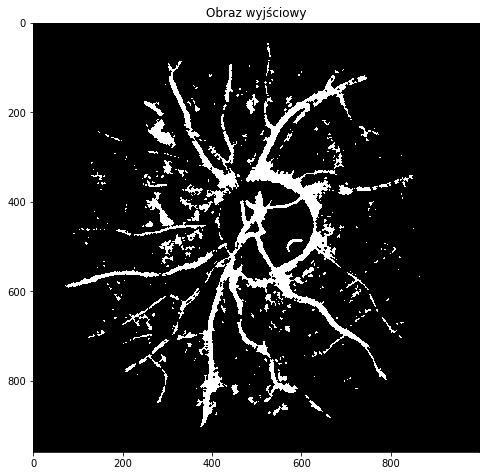

In [671]:
a = image(selector.value[0])
plt.figure(figsize=(8, 8))
plt.title('Obraz wyjściowy')
plt.imshow(a, cmap = plt.cm.gray)

## Maska ekspercka

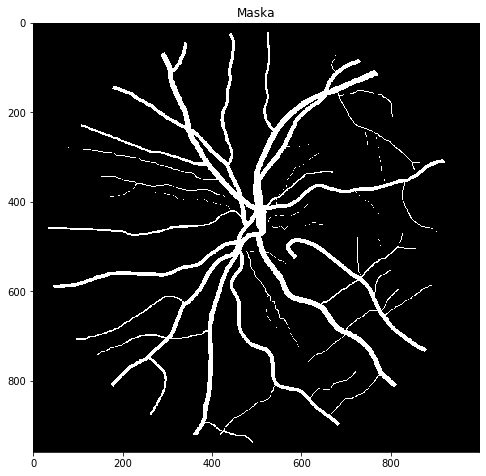

In [672]:
mask = rgb2gray(cv2.imread(selector.value[1]))
plt.figure(figsize=(8, 8))
plt.title('Maska')
plt.imshow(mask, cmap = plt.cm.gray)

## Macierz pomyłek 

trafność: 0.9319798965632299
czułość: 0.5776631531733573
swoistość: 0.9585430782767569
średnia arytmetyczna czułości i swoistości: 0.7681031157250571


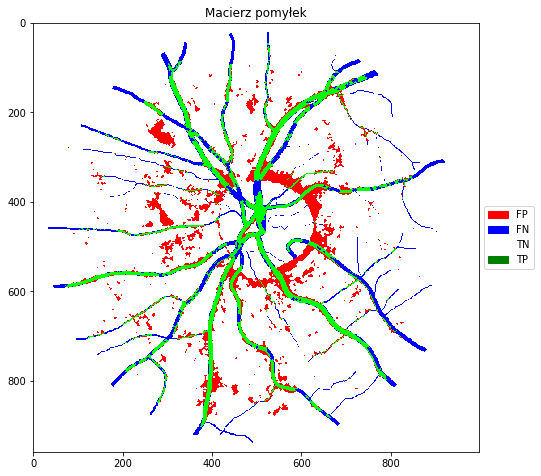

In [673]:
plt.figure(figsize=(8, 8))
plt.title('Macierz pomyłek')
create_matrix(a, img_as_float(cv2.imread(selector.value[1],0)))

## Obraz wyjściowy drzewa decyzyjnego

Cross-validated scores: [0.93765704 0.93545854 0.93323388 0.93564175 0.93333857]
score  0.9350659547738693


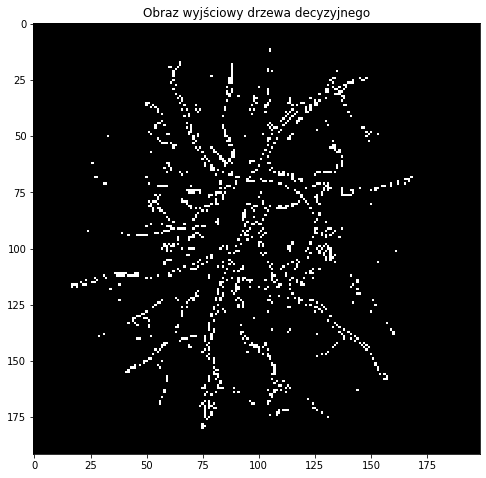

In [674]:
one = ["photos/test/Image_05L.jpg","photos/test/Image_05L_1stHO.png"]
two = ["photos/test/Image_05R.jpg","photos/test/Image_05R_1stHO.png"]
three = ["photos/test/Image_07L.jpg","photos/test/Image_07L_1stHO.png"]
four = ["photos/test/Image_09L.jpg","photos/test/Image_09L_1stHO.png"]
five = ["photos/test/Image_14L.jpg","photos/test/Image_14L_1stHO.png"]
clf = data([one, two, three, four, five])
check = get_features(image(selector.value[0]))
predicted = clf.predict(check)
predict, hand = prepare(image(selector.value[0]), predicted,selector.value[1])
plt.figure(figsize=(8, 8))
plt.title('Obraz wyjściowy drzewa decyzyjnego')
plt.imshow(predict, cmap=plt.cm.gray)

## Macierz pomyłek drzewa decyzyjnego

trafność: 0.9295435510887772
czułość: 0.2310549777117385
swoistość: 0.9824867665277621
średnia arytmetyczna czułości i swoistości: 0.6067708721197503


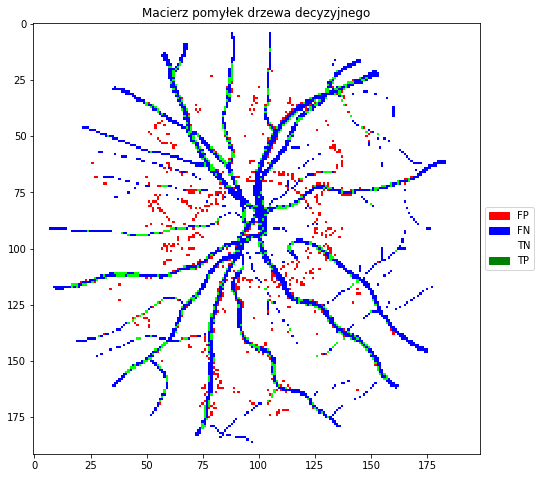

In [675]:
plt.figure(figsize=(8, 8))
plt.title('Macierz pomyłek drzewa decyzyjnego')
create_matrix(predict, hand)